In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# CAVEAT

THIS NOTEBOOK IS JUST AN EXAMPLE OF CURVE FITTING ON SOME REAL WORD DATA.

PLEASE REFRAIN TO TAKE ANY DECISION OR TO EXTRAPOLATE ANY RECOMMANDATION BASED ON THIS NOTEBOOK.

**PLEASE STICK TO OFFICIAL RECOMMENDATION AND INFORMATION!**

* https://www.who.int/emergencies/diseases/novel-coronavirus-2019

# Load the data provided by JHU 

In [2]:
# Data source: https://github.com/CSSEGISandData/COVID-19
!cd DATA && git pull && cd ../

Already up to date.


In [3]:
df_confirmed = pd.read_csv('DATA/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

#df_confirmed = pd.read_csv('DATA/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')

In [4]:
# Drop data from 2020-03-12 because for many country data for this day was a replica from the previous day.
df_confirmed.drop(columns=['3/12/20'], inplace=True)

In [5]:
# Pivot the data: wide to long
df_confirmed_pivoted = df_confirmed.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().to_frame('Cases').reset_index()
df_confirmed_pivoted = df_confirmed_pivoted.rename(columns={'level_4' : 'Date'})
df_confirmed_pivoted['Date'] = pd.to_datetime(df_confirmed_pivoted['Date'])
df_confirmed_pivoted = df_confirmed_pivoted.groupby(['Country/Region','Date'])['Cases'].sum().to_frame('Cases').reset_index()

# Models and other amenities

In [6]:
# Exponential model
def exponential_model(x, *pars): 
    return pars[0]+np.exp(pars[1]*x+pars[2])

# Logistic model
def logistic_model(x, *pars): 
    return pars[0]+pars[1]/(1+np.exp(-pars[2]*(x-pars[3])))

def fit_model(xdata, ydata, model, p0=[1,1,1]):

    popt, pcov = scipy.optimize.curve_fit(model, xdata, ydata,
                                          p0=p0, 
                                          method='trf',
                                          sigma=np.sqrt(ydata),
                                          absolute_sigma=False,
                                          max_nfev=50000)

    r_square = 1 - np.square(ydata-model(xdata, *popt)).sum() / np.var(ydata)
    
    return popt, pcov, r_square

def model_error(xdata, model, pars, cov):
    
    func = lambda pars, args : model(args, *pars)

    eps = np.finfo(np.float16).eps

    err = []
    for x in xdata:
        g = scipy.optimize.approx_fprime(pars, func, eps, x)
        e = np.sqrt(np.dot(g, np.dot(cov,g.T)))
        err.append(e)
        #print(x,popt,g,e)
    
    err=np.array(err)
    return err

def print_fit_results(popt, pcov, r_square):
    
    print('Fit Parameters:')
    print(popt)
    print()
    print('Covariance matrix:')
    print(pcov)
    print()
    print('R-square: %.3f'% r_square)

def forecast(start_date, start_day, n_days, model, popt, pcov):
    
    index = np.arange(start_day, start_day+n_days)
    
    #perr = np.sqrt(np.diag(pcov))
    
    forecast = model(index, *popt)
    error = model_error(index, model, popt, pcov)

    df = pd.DataFrame(
        index=index,
        data={
            'Date': pd.date_range(start=start_date, periods=n_days),
            'Forecast' : forecast,
            '1s_sup' : forecast+error,
            '1s_inf' : forecast-error,
            '2s_sup' : forecast+2*error,
            '2s_inf' : forecast-2*error,
            #'Forecast_sup' : model(index, *(popt+perr)),
            #'Forecast_inf' : model(index, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = error

    return df
    
def predict(dates, days, model, popt, pcov):
    
    #perr = np.sqrt(np.diag(pcov))
    
    pred = model(days, *popt)
    error = model_error(days, model, popt, pcov)

    
    df = pd.DataFrame(
        data={
            'Date': dates,
            'Model' : pred,
            '1s_sup' : pred+error,
            '1s_inf' : pred-error,
            '2s_sup' : pred+2*error,
            '2s_inf' : pred-2*error,
            #'Model_sup' : model(days, *(popt+perr)),
            #'Model_inf' : model(days, *(popt-perr)),
         }
    )
    
    df['Uncertainty'] = error

    return df

# Fit data for Italy

In [17]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
dfit = dfit.loc[dfit['Cases'] > 10]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

ydata=dfit['Cases'] 
xdata=dfit['ndays']

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
p0=[-7.37533982e+02,1.68721374e-01,6.27460550e+00]
popt, pcov, r_square_exp = fit_model(xdata, ydata, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[10, 4.57770247e+04,  2.26454719e-01,  5.34455732e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)


-----------------
Exponential model
-----------------

Fit Parameters:
[-4.29781383e+02  1.78099333e-01  6.04093434e+00]

Covariance matrix:
[[ 1.56344506e+03  1.13226115e-01 -2.44890418e+00]
 [ 1.13226115e-01  1.06794146e-05 -2.20050896e-04]
 [-2.44890418e+00 -2.20050896e-04  4.69972619e-03]]

R-square: 0.923

-----------------
Logistic model
-----------------

Fit Parameters:
[-2.46438831e+02  7.17838877e+04  2.16476572e-01  2.59866286e+01]

Covariance matrix:
[[ 5.00598919e+02 -1.17114937e+05  9.58566877e-02 -1.26046469e+01]
 [-1.17114937e+05  4.87882369e+07 -3.06549864e+01  5.01912380e+03]
 [ 9.58566877e-02 -3.06549864e+01  2.27493801e-05 -3.26292875e-03]
 [-1.26046469e+01  5.01912380e+03 -3.26292875e-03  5.21104366e-01]]

R-square: 0.989


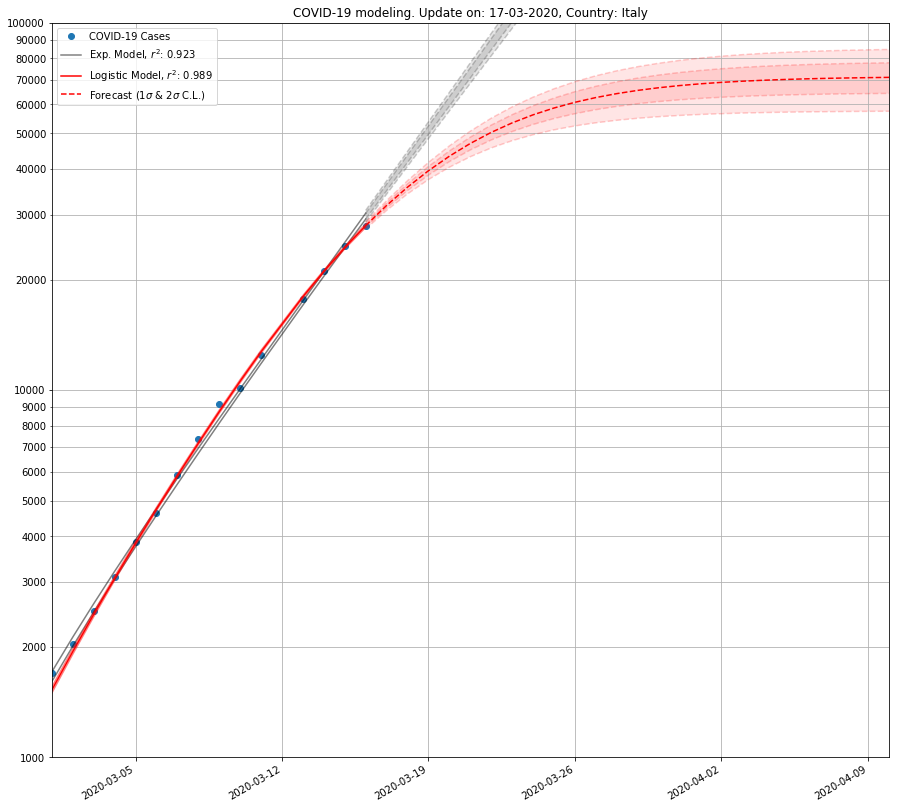

In [18]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit.plot('Date', 'Cases', marker='o', linestyle="None", label='COVID-19 Cases', ax=ax, logy=logy)

# Exponential Model
#df_predict_exp.plot('Date', 'Model', color='k', linestyle='-', alpha=1, label='_nolegend_', ax=ax)
df_predict_exp.plot('Date', '1s_sup', color='k', linestyle='-', alpha=0.5, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax)
df_predict_exp.plot('Date', '1s_inf', color='k', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
# Exponential Model Forecast
#df_forecast_exp.plot('Date', 'Forecast', color='k', linestyle='--', alpha=1, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '1s_sup', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '1s_inf', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '2s_sup', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '2s_inf', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
ax.fill_between(df_forecast_exp['Date'], df_forecast_exp['1s_inf'], df_forecast_exp['1s_sup'], facecolor="k", alpha=0.1)
ax.fill_between(df_forecast_exp['Date'], df_forecast_exp['2s_inf'], df_forecast_exp['2s_sup'], facecolor="k", alpha=0.1)

# Logistic Model
df_predict_logit.plot('Date', 'Model', color='r', linestyle='-', alpha=1, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax)
df_predict_logit.plot('Date', '1s_sup', color='r', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
df_predict_logit.plot('Date', '1s_inf', color='r', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
# Logistic Model Forecast
df_forecast_logit.plot('Date', 'Forecast', color='r', linestyle='--', alpha=1, label='Forecast ($1\sigma$ & $2\sigma$ C.L.)', ax=ax)
df_forecast_logit.plot('Date', '1s_sup', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_logit.plot('Date', '1s_inf', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_logit.plot('Date', '2s_sup', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_logit.plot('Date', '2s_inf', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
ax.fill_between(df_forecast_logit['Date'], df_forecast_logit['2s_inf'], df_forecast_logit['2s_sup'], facecolor="red", alpha=0.1)
ax.fill_between(df_forecast_logit['Date'], df_forecast_logit['1s_inf'], df_forecast_logit['1s_sup'], facecolor="red", alpha=0.1)

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-10'])
ax.set_ylim([1000, 100000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()

## Logistic model: forecast 30 days ahead

In [9]:
display(df_forecast_logit)

,Date,Forecast,1s_sup,1s_inf,2s_sup,2s_inf,Uncertainty
24,2020-03-16,28044.477965,28349.132040,27739.823890,28653.786116,27435.169814,304.654075
25,2020-03-17,31827.073436,32314.438821,31339.708052,32801.804206,30852.342667,487.365385
26,2020-03-18,35697.451372,36439.109012,34955.793733,37180.766651,34214.136094,741.657639
27,2020-03-19,39566.621597,40630.639003,38502.604190,41694.656410,37438.586783,1064.017407
28,2020-03-20,43345.704319,44792.392398,41899.016239,46239.080478,40452.328159,1446.688080
29,2020-03-21,46953.911593,48831.254889,45076.568297,50708.598186,43199.225000,1877.343296
30,2020-03-22,50325.031971,52665.228402,47984.835539,55005.424833,45644.639108,2340.196431
31,2020-03-23,53411.399414,56229.327240,50593.471589,59047.255065,47775.543763,2817.927826
32,2020-03-24,56185.031348,59478.784512,52891.278184,62772.537676,49597.525019,3293.753164
33,2020-03-25,58636.289206,62389.403224,54883.175189,66142.517241,51130.061171,3753.114018


## Fit stability

In [10]:
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'Italy'].reset_index(drop=True)
dfit = dfit.loc[dfit['Cases'] > 10]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

ydata=dfit['Cases'] 
xdata=dfit['ndays']

p0=popt

fit_stab = []

for i in range(len(xdata))[::-1]:
    
    if i != 0:
        
        popt, pcov, r_square_logit = fit_model(xdata[:i],ydata[:i],logistic_model, p0=p0)
        fit_stab.append({
            'x': xdata.iloc[i],
            'date' : dfit['Date'].iloc[i],
            'popt' : popt, 
            'perr' : np.sqrt(np.diag(pcov)), 
            'r_square' : r_square_logit
        })

In [11]:
df=pd.DataFrame(fit_stab)

tmp_1=df.date.apply(pd.Series)
tmp_1.columns=['date']
tmp_2=df.popt.apply(pd.Series)
tmp_2.columns=['popt_0', 'popt_1', 'popt_2', 'popt_3']
tmp_3=df.perr.apply(pd.Series)
tmp_3.columns=['perr_0', 'perr_1', 'perr_2', 'perr_3']

df = pd.concat([tmp_1, tmp_2, tmp_3, df.r_square], axis=1)

df = df.sort_values(by='date').reset_index(drop=True)

In [12]:
df

,date,popt_0,popt_1,popt_2,popt_3,perr_0,perr_1,perr_2,perr_3,r_square
0,2020-02-22,-246.438831,7.178389e+04,0.215407,25.986620,inf,inf,inf,inf,-inf
1,2020-02-23,-245.399176,7.178389e+04,0.147501,37.941869,inf,inf,inf,inf,1.000000
2,2020-02-24,-14.506627,7.178389e+04,0.796812,9.587936,inf,inf,inf,inf,1.000000
3,2020-02-25,6.758999,2.534311e+02,1.620591,1.788306,inf,inf,inf,inf,1.000000
4,2020-02-26,-19.860645,4.248283e+02,0.908963,2.510480,38.573078,1.560218e+02,0.420258,0.595445,0.978981
5,2020-02-27,-87.353504,1.016247e+03,0.450137,4.769329,110.754945,1.043394e+03,0.332187,3.618915,0.978569
6,2020-02-28,-171.776353,2.181626e+07,0.241938,48.140467,53.231557,1.205011e-06,0.036987,6.271727,0.980194
7,2020-02-29,-160.374735,4.670914e+07,0.251051,49.663935,32.912196,3.210548e-07,0.022256,3.731994,0.988659
8,2020-03-01,-150.718726,9.201545e+03,0.269897,14.721416,68.867922,2.240082e+04,0.083583,12.266873,0.988736
9,2020-03-02,-137.275969,2.874771e+08,0.267562,53.871486,26.495686,3.658075e-08,0.016642,2.813149,0.951067


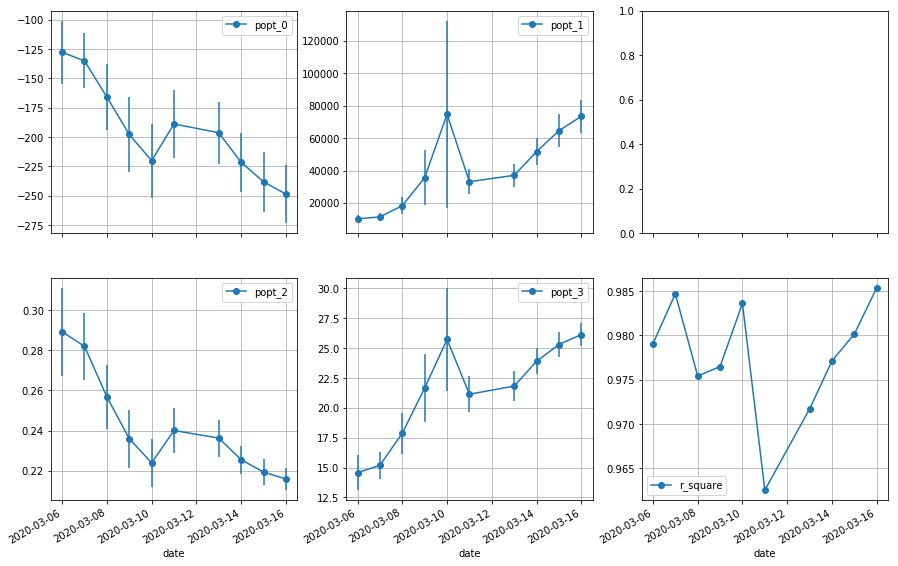

In [13]:

f, ax = plt.subplots(2, 3, sharex=True, figsize=(15,10))

df[-10:].plot(x='date', y='popt_0', yerr='perr_0', marker='o', grid=True, ax=ax[0][0])
df[-10:].plot(x='date', y='popt_1', yerr='perr_1', marker='o', grid=True, ax=ax[0][1])
df[-10:].plot(x='date', y='popt_2', yerr='perr_2', marker='o', grid=True, ax=ax[1][0])
df[-10:].plot(x='date', y='popt_3', yerr='perr_3', marker='o', grid=True, ax=ax[1][1])
df[-10:].plot(x='date', y='r_square', marker='o', grid=True, ax=ax[1][2])

#plt.xlabel('')

plt.show()

# Fit data for France

In [14]:
# The same fit works for other country, but the intitial fit parameters must be carefully tuned
dfit = df_confirmed_pivoted.loc[df_confirmed_pivoted['Country/Region'] == 'France'].reset_index(drop=True)

# Drop 15/03/2020 because the data is suspicously close to the previous day
dfit=dfit.drop(52, axis=0)

dfit = dfit.loc[dfit['Cases'] > 100]

dfit['ndays'] = (dfit['Date'] - dfit['Date'].iloc[0]).dt.days

ydata=dfit['Cases'] 
xdata=dfit['ndays']

# Exponential model
print()
print('-----------------')
print('Exponential model')
print('-----------------')
print()
p0=[ 0.50341354,  0.5, -0.6697555 ]
popt, pcov, r_square_exp = fit_model(xdata, ydata, exponential_model, p0=p0)
print_fit_results(popt, pcov, r_square_exp)
df_predict_exp = predict(dfit['Date'].values, dfit['ndays'].values, exponential_model, popt, pcov)
df_forecast_exp = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 10, exponential_model, popt, pcov)

# Logistic model
print()
print('-----------------')
print('Logistic model')
print('-----------------')
print()
p0=[7.27827841e+00, 9.39938381e+03, 3.32193436e-01, 3.53736033e+01]
popt, pcov, r_square_logit = fit_model(xdata,ydata,logistic_model, p0=p0)
print_fit_results(popt, pcov, r_square_logit)
df_predict_logit = predict(dfit['Date'].values, dfit['ndays'].values, logistic_model, popt, pcov)
df_forecast_logit = forecast(dfit['Date'].values[-1], dfit['ndays'].values[-1], 30, logistic_model, popt, pcov)


-----------------
Exponential model
-----------------

Fit Parameters:
[-180.72782078    0.21618013    5.61723492]

Covariance matrix:
[[ 3.41794704e+03  5.44281375e-01 -7.79104584e+00]
 [ 5.44281375e-01  1.06024818e-04 -1.43900056e-03]
 [-7.79104584e+00 -1.43900056e-03  2.01521340e-02]]

R-square: 0.957

-----------------
Logistic model
-----------------

Fit Parameters:
[-4.97422064e+01  1.74776867e+04  2.78036663e-01  1.67288374e+01]

Covariance matrix:
[[ 4.30503483e+03 -3.72601510e+05  1.93522468e+00 -1.29084883e+02]
 [-3.72601510e+05  5.22511490e+07 -2.19369721e+02  1.75413264e+04]
 [ 1.93522468e+00 -2.19369721e+02  1.03914843e-03 -7.53986618e-02]
 [-1.29084883e+02  1.75413264e+04 -7.53986618e-02  5.92638840e+00]]

R-square: 0.980


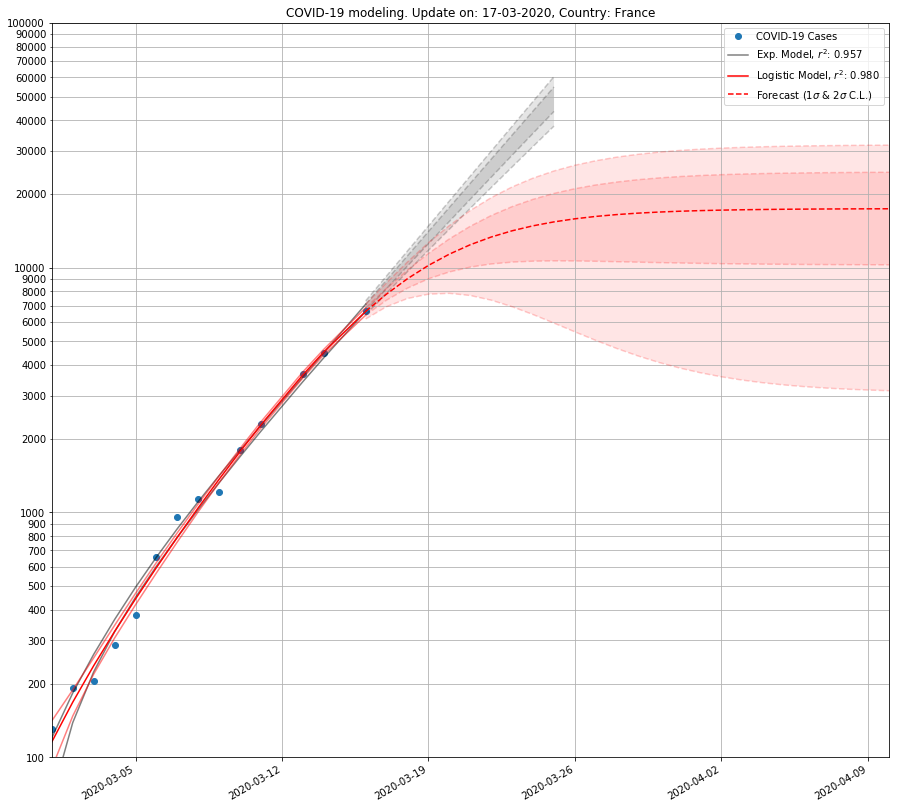

In [15]:
# Draw
_,ax = plt.subplots(figsize=(15,15))
logy=True
# Data
dfit.plot('Date', 'Cases', marker='o', linestyle="None", label='COVID-19 Cases', ax=ax, logy=logy)

# Exponential Model
#df_predict_exp.plot('Date', 'Model', color='k', linestyle='-', alpha=1, label='_nolegend_', ax=ax)
df_predict_exp.plot('Date', '1s_sup', color='k', linestyle='-', alpha=0.5, label='Exp. Model, $r^2$: %.3f'% r_square_exp, ax=ax)
df_predict_exp.plot('Date', '1s_inf', color='k', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
# Exponential Model Forecast
#df_forecast_exp.plot('Date', 'Forecast', color='k', linestyle='--', alpha=1, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '1s_sup', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '1s_inf', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '2s_sup', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_exp.plot('Date', '2s_inf', color='k', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
ax.fill_between(df_forecast_exp['Date'], df_forecast_exp['1s_inf'], df_forecast_exp['1s_sup'], facecolor="k", alpha=0.1)
ax.fill_between(df_forecast_exp['Date'], df_forecast_exp['2s_inf'], df_forecast_exp['2s_sup'], facecolor="k", alpha=0.1)

# Logistic Model
df_predict_logit.plot('Date', 'Model', color='r', linestyle='-', alpha=1, label='Logistic Model, $r^2$: %.3f'% r_square_logit, ax=ax)
df_predict_logit.plot('Date', '1s_sup', color='r', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
df_predict_logit.plot('Date', '1s_inf', color='r', linestyle='-', alpha=0.5, label='_nolegend_', ax=ax)
# Logistic Model Forecast
df_forecast_logit.plot('Date', 'Forecast', color='r', linestyle='--', alpha=1, label='Forecast ($1\sigma$ & $2\sigma$ C.L.)', ax=ax)
df_forecast_logit.plot('Date', '1s_sup', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_logit.plot('Date', '1s_inf', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_logit.plot('Date', '2s_sup', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
df_forecast_logit.plot('Date', '2s_inf', color='r', linestyle='--', alpha=0.2, label='_nolegend_', ax=ax)
ax.fill_between(df_forecast_logit['Date'], df_forecast_logit['2s_inf'], df_forecast_logit['2s_sup'], facecolor="red", alpha=0.1)
ax.fill_between(df_forecast_logit['Date'], df_forecast_logit['1s_inf'], df_forecast_logit['1s_sup'], facecolor="red", alpha=0.1)

formatter = matplotlib.ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_minor_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

from datetime import datetime    
plt.title('COVID-19 modeling. Update on: %s, Country: %s' %(datetime.today().strftime('%d-%m-%Y'),dfit['Country/Region'].values[0]))
plt.grid(axis='both',which='both')
plt.xlabel('')

#Axis limit
ax.set_xlim(['2020-03-01','2020-04-10'])
ax.set_ylim([100, 100000])

# Zoom
#ax.set_xlim(['2020-03-13','2020-03-16'])
#ax.set_ylim([20000, 28000])

plt.show()